# Aphid-Ladybeetle study

In [1]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd
import warnings

np.seterr('raise')
warnings.filterwarnings("ignore")

## Obtaining Initial Conditions

We need to define Initial Conditions as functions in order to define them for each discretization point. Here we will fit ICs as polynomial functions.

Loading data:

### 1987_Banks_et_al

data_dir = "../data/aphid_ladybird/1987_Banks_et_al/"
aphid_data = pd.read_excel(data_dir + 'aphid.xls')
ladybeetle_data = pd.read_excel(data_dir + 'ladybeetle.xls')

### 2014_Messelink

### 2017_Lin_and_Pennings

In [2]:
data_dir = "../data/2017 Lin and Pennings/appendix/"
aphid_data = pd.read_csv(data_dir + 'aphid.CSV')
ladybeetle_data = pd.read_csv(data_dir + 'ladybeetle.CSV')

### 2018_Beltra_et_al

In [3]:
aphid_data

,Location,Time,Date,Location_code,Patch_ID,Density
0,NaN,1,NaN,NaN,NaN,2356.456977
1,NaN,2,NaN,NaN,NaN,2615.616657
2,NaN,3,NaN,NaN,NaN,2561.262823
3,NaN,4,NaN,NaN,NaN,2312.305026
4,NaN,5,NaN,NaN,NaN,3084.968851
5,NaN,6,NaN,NaN,NaN,3084.650335
6,NaN,7,NaN,NaN,NaN,2987.043890
7,NaN,8,NaN,NaN,NaN,2575.933299
8,NaN,9,NaN,NaN,NaN,2424.272800
9,NaN,10,NaN,NaN,NaN,2802.351398


In [4]:
ladybeetle_data

,Location,Time,Date,Location_code,Patch_ID,Density
0,NaN,1,NaN,NaN,NaN,7.106599
1,NaN,2,NaN,NaN,NaN,8.151265
2,NaN,3,NaN,NaN,NaN,7.103533
3,NaN,4,NaN,NaN,NaN,5.077605
4,NaN,5,NaN,NaN,NaN,4.097805
5,NaN,6,NaN,NaN,NaN,3.104325
6,NaN,7,NaN,NaN,NaN,2.083813
7,NaN,8,NaN,NaN,NaN,3.101259
8,NaN,9,NaN,NaN,NaN,4.077991
9,NaN,10,NaN,NaN,NaN,3.084606


Retrieving IC data:

In [5]:
aphid_ic = aphid_data[aphid_data.Time == 1].Density.values[0]
ladybeetle_ic = ladybeetle_data[ladybeetle_data.Time == 1].Density.values[0]

In [6]:
aphid_ic

2356.45697690758

In [7]:
ladybeetle_ic

7.10659898477157

In [8]:
y0_BKM = aphid_ic, ladybeetle_ic

y0_BKM

(2356.45697690758, 7.10659898477157)

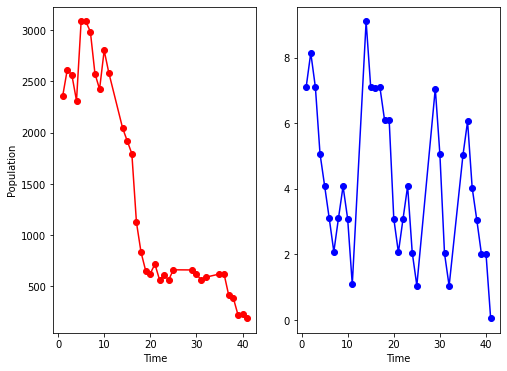

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

ax1.plot(aphid_data.Time.values, aphid_data.Density.values, '-o', c='r')
ax1.set(xlabel='Time', ylabel='Population')
ax2.plot(ladybeetle_data.Time.values, ladybeetle_data.Density.values, '-o', c='b')
ax2.set(xlabel='Time')
plt.show()

# Prey-Predator Banks-Kareiva-Murphy A model

In [10]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def BKM_model(
    t,
    X,
    r1 = 0.136,
    r2 = 0.48e-3,
    p = 0.032,
    i = 11.0,
    e1 = 0.0012,
    e2 = 20.9,
    e3 = 0.009,
):
    """
    Prey-Predator Banks-Kareiva-Murphy A model (BKM) python implementation.
    """
    u, v = X
    u_prime = r1 * u - r2 * u * u - p * u * v
    v_prime = i - ( e1 + e2 * np.exp( - e3 * u ) ) * v
    return u_prime, v_prime

def BKM_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 0.136,
    r2 = 0.48e-3,
    p = 0.032,
    i = 11.0,
    e1 = 0.0012,
    e2 = 20.9,
    e3 = 0.009,
):
    solution_ODE = solve_ivp(
        fun=BKM_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1, r2, p, i, e1, e2, e3),
        method="LSODA",
    )
    return solution_ODE

# Testing
#y0_BKM = 1000, 10
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
t0 = 0
tf = 60
days_to_forecast = 0
#time_range = np.linspace(t0, tf + days_to_forecast, tf)
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

#solution_ODE_BKM = BKM_ode_solver(y0_BKM,(t0, tf + days_to_forecast),time_range,r1=84.3076043709435,r2=3.6171452070781938e-09,p=8.42165671556821,i=0.02313343678899621,e1=5.2382389737075074e-08,e2=0.0024303746376647104,e3=4.9340194538713404e-05)
#t_computed_BKM, y_computed_BKM = solution_ODE_BKM.t, solution_ODE_BKM.y
#aphid_analytic, ladybeetle_analytic = y_computed_BKM

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [11]:
def BKM_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1e3
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [12]:
from scipy import optimize

seed = 1234

r1=46.32166847737433
r2=9.533324619539296e-09
p=6.506856453951996
i=0.03097896528819232
e1=6.774786031845174e-08
e2=0.004623799343568372
e3=5.1998548164782127e-05

denom_min = 0.7
denom_max = 1.3
bounds_BKM = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( p * denom_min ), ( p * denom_max ) ),    # p
    ( ( i * denom_min ), ( i * denom_max ) ),    # i
    ( ( e1 * denom_min ), ( e1 * denom_max ) ),  # e1
    ( ( e2 * denom_min ), ( e2 * denom_max ) ),  # e2
    ( ( e3 * denom_min ), ( e3 * denom_max ) ),  # e3
]

result_BKM = optimize.differential_evolution(
    BKM_least_squares_error_ode,
    bounds=bounds_BKM,
    args=(
        aphid_data.Time.values,
        [u_data, v_data],
        BKM_ode_solver,
        y0_BKM,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=2000,
    polish=True,
    disp=True,
    seed = seed,
    callback=callback_de,
    workers=-1,
)

print(result_BKM)

differential_evolution step 1: f(x)= 5.95976e+06
parameters = [3.65028187e+01 1.12773621e-08 5.12299070e+00 3.47032530e-02
 6.62236221e-08 4.61048635e-03 4.04255953e-05]

differential_evolution step 2: f(x)= 5.95976e+06
parameters = [3.65028187e+01 1.12773621e-08 5.12299070e+00 3.47032530e-02
 6.62236221e-08 4.61048635e-03 4.04255953e-05]

differential_evolution step 3: f(x)= 5.487e+06
parameters = [3.34439616e+01 1.00778262e-08 4.68363095e+00 3.61283196e-02
 5.29703160e-08 4.85459001e-03 3.86730802e-05]

differential_evolution step 4: f(x)= 5.487e+06
parameters = [3.34439616e+01 1.00778262e-08 4.68363095e+00 3.61283196e-02
 5.29703160e-08 4.85459001e-03 3.86730802e-05]

differential_evolution step 5: f(x)= 1.48997e+06
parameters = [3.25906521e+01 1.01522752e-08 4.57555425e+00 3.23710416e-02
 5.04651262e-08 4.67608809e-03 4.49289149e-05]

differential_evolution step 6: f(x)= 1.48997e+06
parameters = [3.25906521e+01 1.01522752e-08 4.57555425e+00 3.23710416e-02
 5.04651262e-08 4.67608809

differential_evolution step 49: f(x)= 1.06959e+06
parameters = [3.49129209e+01 1.23619250e-08 4.90139012e+00 3.65913831e-02
 6.80608798e-08 5.49828593e-03 5.85176912e-05]

differential_evolution step 50: f(x)= 1.06959e+06
parameters = [3.49129209e+01 1.23619250e-08 4.90139012e+00 3.65913831e-02
 6.80608798e-08 5.49828593e-03 5.85176912e-05]

differential_evolution step 51: f(x)= 1.06959e+06
parameters = [3.49129209e+01 1.23619250e-08 4.90139012e+00 3.65913831e-02
 6.80608798e-08 5.49828593e-03 5.85176912e-05]

differential_evolution step 52: f(x)= 1.06959e+06
parameters = [3.49129209e+01 1.23619250e-08 4.90139012e+00 3.65913831e-02
 6.80608798e-08 5.49828593e-03 5.85176912e-05]

differential_evolution step 53: f(x)= 1.06959e+06
parameters = [3.49129209e+01 1.23619250e-08 4.90139012e+00 3.65913831e-02
 6.80608798e-08 5.49828593e-03 5.85176912e-05]

differential_evolution step 54: f(x)= 1.06959e+06
parameters = [3.49129209e+01 1.23619250e-08 4.90139012e+00 3.65913831e-02
 6.80608798e-08 

differential_evolution step 97: f(x)= 1.06954e+06
parameters = [3.54966619e+01 1.20101382e-08 4.98353595e+00 3.63062520e-02
 8.27024545e-08 5.45171439e-03 5.79330116e-05]

differential_evolution step 98: f(x)= 1.06954e+06
parameters = [3.54966619e+01 1.20101382e-08 4.98353595e+00 3.63062520e-02
 8.27024545e-08 5.45171439e-03 5.79330116e-05]

differential_evolution step 99: f(x)= 1.06954e+06
parameters = [3.54966619e+01 1.20101382e-08 4.98353595e+00 3.63062520e-02
 8.27024545e-08 5.45171439e-03 5.79330116e-05]

differential_evolution step 100: f(x)= 1.06954e+06
parameters = [3.54966619e+01 1.20101382e-08 4.98353595e+00 3.63062520e-02
 8.27024545e-08 5.45171439e-03 5.79330116e-05]

differential_evolution step 101: f(x)= 1.06954e+06
parameters = [3.54966619e+01 1.20101382e-08 4.98353595e+00 3.63062520e-02
 8.27024545e-08 5.45171439e-03 5.79330116e-05]

differential_evolution step 102: f(x)= 1.06954e+06
parameters = [3.54966619e+01 1.20101382e-08 4.98353595e+00 3.63062520e-02
 8.27024545e-

* Retrieving the calibrated parameter values:

In [13]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    p_deterministic,
    i_deterministic,
    e1_deterministic,
    e2_deterministic,
    e3_deterministic,
) = result_BKM.x

solution_ODE_BKM = BKM_ode_solver(
    y0_BKM,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_BKM.x
)
t_computed_BKM, y_computed_BKM = solution_ODE_BKM.t, solution_ODE_BKM.y
u_BKM, v_BKM = y_computed_BKM

parameters_dict = {
    "Model": "BKM",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$p$": p_deterministic,
    u"$i$": i_deterministic,
    u"$e1$": e1_deterministic,
    u"$e2$": e2_deterministic,
    u"$e3$": e3_deterministic,
}

r1,r2,p,i,e1,e2,e3, = r1_deterministic,r2_deterministic,p_deterministic,i_deterministic,e1_deterministic,e2_deterministic,e3_deterministic,

print("r1=" + str(r1) + "\n" + "r2=" + str(r2) + "\n" + "p=" + str(p) + "\n" + "i=" + str(i) + "\n" + "e1=" + str(e1) + "\n" + "e2=" + str(e2) + "\n" + "e3=" + str(e3))

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=35.56690872979918
r2=1.1713131956788192e-08
p=4.993421277966288
i=0.03624584574847937
e1=8.230520196179339e-08
e2=0.005442601935340863
e3=5.791828266406886e-05


#### Simulation

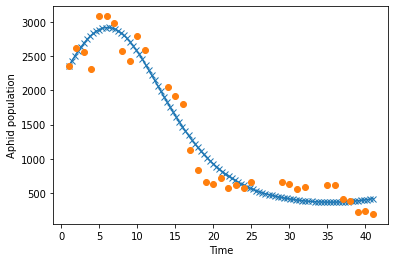

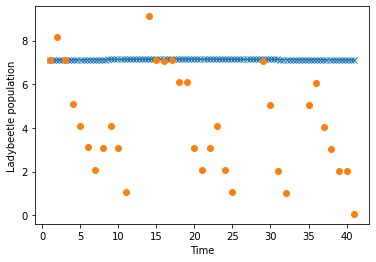

In [14]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_BKM, u_BKM, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_BKM, v_BKM, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

# Sensitivity Analyses

## Least-Squares objective function

In [15]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    p,
    i,
    e1,
    e2,
    e3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$p$",
    r"$i$",
    r"$e1$",
    r"$e2$",
    r"$e3$",
]
params_perturbations = 0.75
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [16]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = BKM_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        BKM_ode_solver,
        y0_BKM
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 32/32 [00:00<00:00, 382.97it/s]


In [17]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

,$\mu^*$
$p$,0.458995
$r1$,0.443509
$r2$,0.074769
$i$,0.0225628
$e2$,0.000121623
$e3$,4.21422e-05
$e1$,3.20097e-08


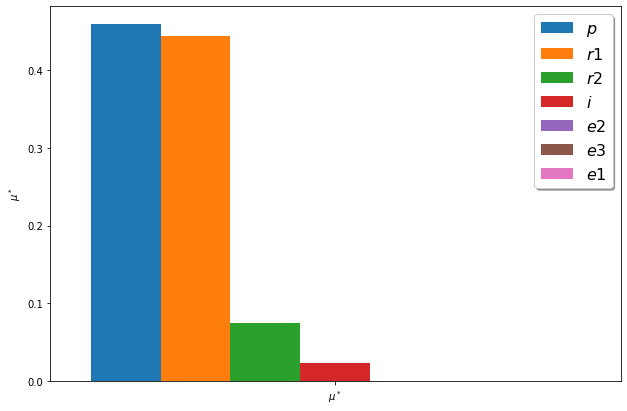

In [18]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("sensitivity_least_squares.png", dpi=300)
plt.show()

## Prey (pest) population

In [19]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    p,
    i,
    e1,
    e2,
    e3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$p$",
    r"$i$",
    r"$e1$",
    r"$e2$",
    r"$e3$",
]
params_perturbations = 0.75
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [20]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_BKM = BKM_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_BKM.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 32/32 [00:00<00:00, 346.52it/s]


In [21]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 136.57it/s]


,Time,$r1$,$r2$,$p$,$i$,$e1$,$e2$,$e3$
0,1.404040,0.500922,4.45112e-05,0.49902,8.211e-06,3.91355e-10,2.2199e-06,2.31828e-06
1,1.808081,0.481628,0.0737914,0.442113,0.00200956,1.07373e-08,0.000348014,0.00011054
2,2.212121,0.425777,0.184683,0.38719,0.00214955,8.38336e-09,0.000147278,5.27887e-05
3,2.616162,0.425034,0.184739,0.387207,0.00282952,1.12501e-08,0.000140199,5.02475e-05
4,3.020202,0.424503,0.18429,0.387455,0.00356211,1.41645e-08,0.00014008,5.02087e-05
...,...,...,...,...,...,...,...,...
94,39.383838,0.378552,0.145879,0.408676,0.06671,2.83577e-07,0.000134552,4.82213e-05
95,39.787879,0.378062,0.14547,0.408903,0.0673826,2.86535e-07,0.000134494,4.82002e-05
96,40.191919,0.377574,0.145061,0.409128,0.0680545,2.89491e-07,0.000134435,4.81791e-05
97,40.595960,0.377085,0.144652,0.409354,0.0687259,2.92444e-07,0.000134376,4.8158e-05


In [22]:
df_sigmai

,Time,$r1$,$r2$,$p$,$i$,$e1$,$e2$,$e3$
0,1.404040,0.499505,5.37667e-05,0.500429,8.10508e-06,4.49208e-10,2.15516e-06,2.65204e-06
1,1.808081,0.458153,0.0595412,0.479211,0.00245571,1.39852e-08,0.000487044,0.000152509
2,2.212121,0.383576,0.189178,0.423324,0.0035543,1.34972e-08,0.000273014,9.50627e-05
3,2.616162,0.382473,0.189317,0.423195,0.00466539,1.81047e-08,0.000259604,9.02535e-05
4,3.020202,0.381825,0.18852,0.423442,0.00586384,2.27736e-08,0.000259008,9.00524e-05
...,...,...,...,...,...,...,...,...
94,39.383838,0.331522,0.126625,0.444759,0.0967981,3.95628e-07,0.000219222,7.62094e-05
95,39.787879,0.331051,0.126035,0.444979,0.0976408,3.99182e-07,0.000218828,7.60725e-05
96,40.191919,0.330581,0.125446,0.445198,0.0984804,4.02722e-07,0.000218436,7.59359e-05
97,40.595960,0.330113,0.124859,0.445416,0.0993169,4.06248e-07,0.000218044,7.57997e-05


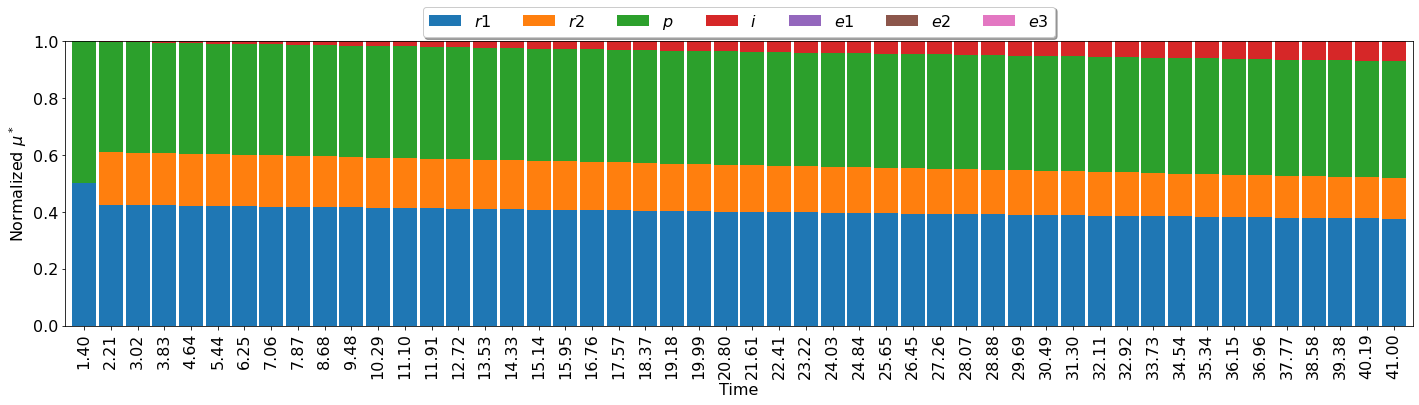

In [23]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("SA_pest_pop.png", dpi=300)
plt.show()

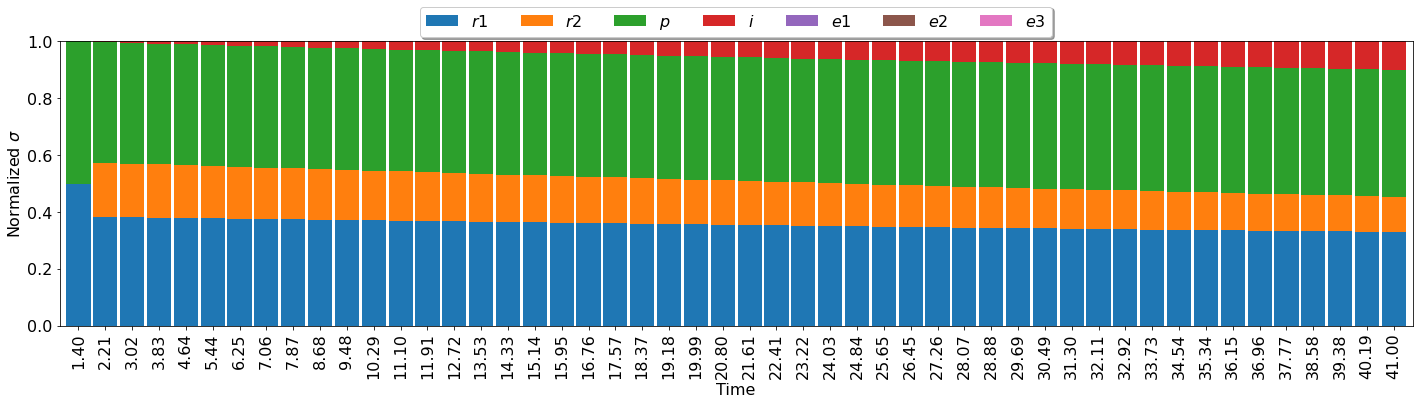

In [24]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("SA_pest_pop_sigma.png", dpi=300)
plt.show()

## Time-derivative of pest (prey) population

In [25]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [26]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_BKM,
    u_BKM,
    v_BKM,
    BKM_model,
    mean_values_params
)

pest_time_derivative_array

array([ 1.90021259e+02,  1.82701529e+02,  1.74468208e+02,  1.64536178e+02,
        1.52925492e+02,  1.39681488e+02,  1.24904373e+02,  1.08572791e+02,
        9.11823964e+01,  7.26404338e+01,  5.31508004e+01,  3.29894049e+01,
        1.24190591e+01, -8.28331182e+00, -2.88298160e+01, -4.89726911e+01,
       -6.84699937e+01, -8.70822873e+01, -1.04582251e+02, -1.20794584e+02,
       -1.35585754e+02, -1.48827177e+02, -1.60415466e+02, -1.70311962e+02,
       -1.78515051e+02, -1.85035396e+02, -1.89928741e+02, -1.93257592e+02,
       -1.95122379e+02, -1.95637946e+02, -1.94924216e+02, -1.93096231e+02,
       -1.90278091e+02, -1.86606967e+02, -1.82222161e+02, -1.77245833e+02,
       -1.71774805e+02, -1.65918651e+02, -1.59782560e+02, -1.53450824e+02,
       -1.46992737e+02, -1.40481231e+02, -1.34075190e+02, -1.27576150e+02,
       -1.21203343e+02, -1.14980987e+02, -1.08930152e+02, -1.03063156e+02,
       -9.73922329e+01, -9.19293538e+01, -8.66832247e+01, -8.16552903e+01,
       -7.68484142e+01, -

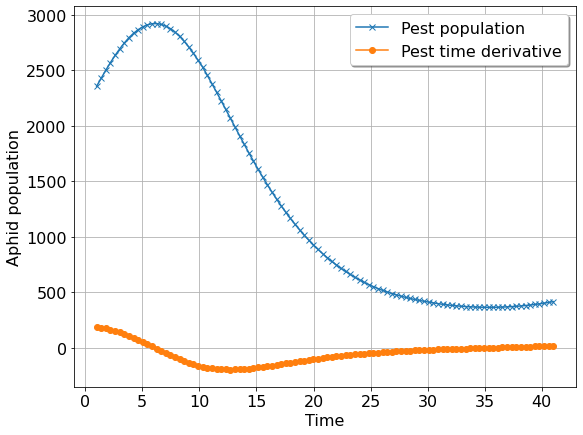

In [27]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_BKM, u_BKM, '-x', label='Pest population')
plt.plot(t_computed_BKM, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("pest_derivative.png", dpi=300)
plt.show()

In [28]:
mean_values_params = [
    r1,
    r2,
    p,
    i,
    e1,
    e2,
    e3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$p$",
    r"$i$",
    r"$e1$",
    r"$e2$",
    r"$e3$",
]
params_perturbations = 0.75
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [29]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_BKM = BKM_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_BKM.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        BKM_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 32/32 [00:00<00:00, 208.49it/s]


In [30]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 141.24it/s]


,Time,$r1$,$r2$,$p$,$i$,$e1$,$e2$,$e3$
0,1.404040,0.506972,0.000694839,0.49225,7.19637e-05,2.29878e-10,6.03366e-06,5.32181e-06
1,1.808081,0.398112,0.193973,0.396899,0.00906988,8.43672e-09,0.00146618,0.00048073
2,2.212121,0.384104,0.244711,0.329124,0.0366284,2.32257e-07,0.00400699,0.00142471
3,2.616162,0.147575,0.143075,0.423064,0.286147,1.13388e-06,0.00010299,3.3543e-05
4,3.020202,0.139667,0.136713,0.42721,0.296345,1.18068e-06,5.21811e-05,1.15219e-05
...,...,...,...,...,...,...,...,...
94,39.383838,0.141382,0.150129,0.420704,0.287766,1.3203e-06,1.38803e-05,3.08902e-06
95,39.787879,0.14227,0.151086,0.419889,0.286737,1.32883e-06,1.43361e-05,3.21715e-06
96,40.191919,0.143212,0.152101,0.419027,0.285641,1.33783e-06,1.48055e-05,3.35003e-06
97,40.595960,0.144213,0.153177,0.418115,0.284474,1.34732e-06,1.52891e-05,3.48788e-06


In [31]:
df_sigmai

,Time,$r1$,$r2$,$p$,$i$,$e1$,$e2$,$e3$
0,1.404040,0.497028,0.000731037,0.502166,6.45555e-05,1.98138e-10,5.27994e-06,5.19455e-06
1,1.808081,0.398624,0.189082,0.397948,0.0117407,1.06981e-08,0.00196272,0.000643538
2,2.212121,0.379506,0.255212,0.325174,0.0338528,2.26224e-07,0.00461442,0.00164036
3,2.616162,0.161476,0.127844,0.396573,0.313934,1.22466e-06,0.000129288,4.20667e-05
4,3.020202,0.155529,0.125183,0.394704,0.324505,1.26191e-06,6.47552e-05,1.42449e-05
...,...,...,...,...,...,...,...,...
94,39.383838,0.161599,0.1249,0.393492,0.319986,1.4119e-06,1.77106e-05,3.94103e-06
95,39.787879,0.162616,0.12578,0.392963,0.318617,1.42152e-06,1.83067e-05,4.10787e-06
96,40.191919,0.163699,0.126716,0.392403,0.317157,1.43171e-06,1.8922e-05,4.28127e-06
97,40.595960,0.164849,0.127711,0.391812,0.315603,1.4425e-06,1.95575e-05,4.46154e-06


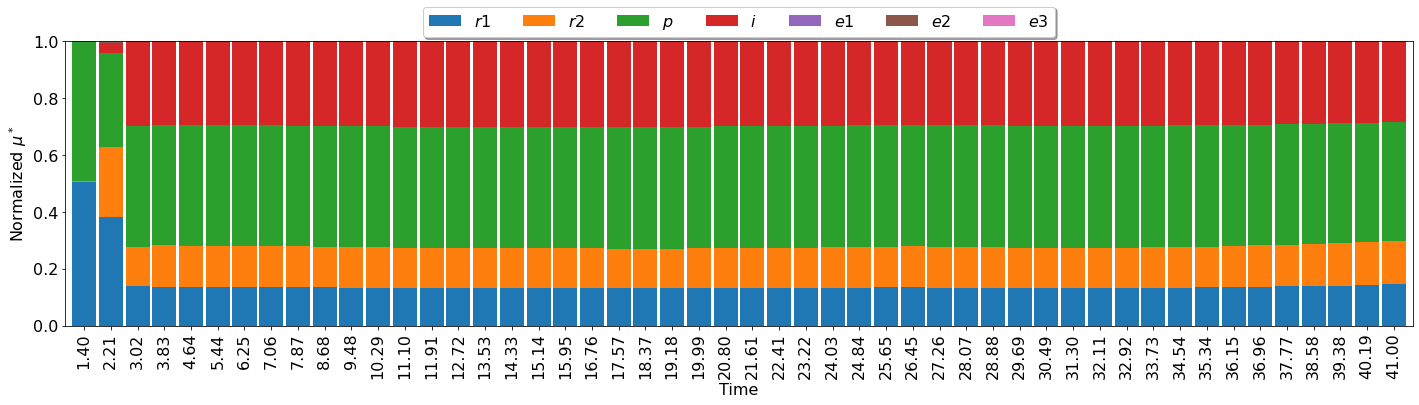

In [32]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("SA_pest_pop_derivative.png", dpi=300)
plt.show()

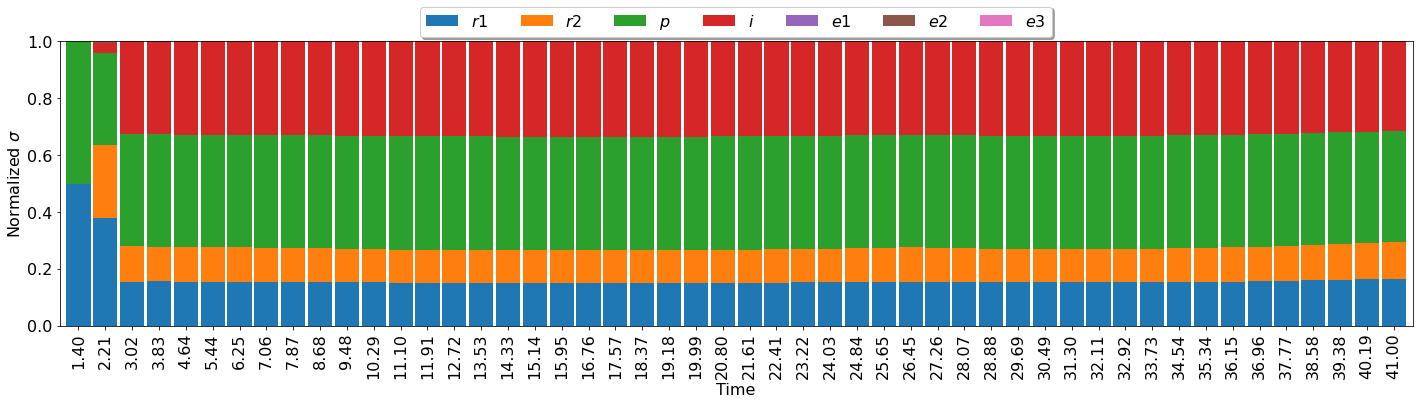

In [33]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("SA_pest_pop_sigma_derivative.png", dpi=300)
plt.show()

# Bayesian calibration

In [34]:
import theano  # to control better pymc3 backend and write a wrapper
import theano.tensor as t  # for the wrapper to a custom model to pymc3
THEANO_FLAGS = "optimizer=fast_compile"  # A theano trick

@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # r2
        t.dscalar,  # p
        t.dscalar,  # i
        t.dscalar,  # e1
        t.dscalar,  # e2
        t.dscalar,  # e3
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def BKM_ode_wrapper(time_exp, r1, r2, p, i, e1, e2, e3, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, r2, p, i, e1, e2, e3]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        BKM_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [35]:
import pymc3 as pm  # for uncertainty quantification and model calibration
import time

observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.9
with pm.Model() as model_smc:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
    r2_ = pm.Uniform(
        "r2", 
        lower=0,  # (1.0 - percent_calibration) * r2, 
        upper=1e-2  # (1.0 + percent_calibration) * r2,
    )
#     r2_ = pm.Data("r2", r2)  # r2 values tend to zero
    p_ = pm.Uniform(
        "p", 
        lower=(1.0 - percent_calibration) * p, 
        upper=(1.0 + percent_calibration) * p,
    )
#     i_ = pm.Uniform(
#         "i", 
#         lower=(1.0 - percent_calibration) * i, 
#         upper=(1.0 + percent_calibration) * i,
#     )
    i_ = pm.Data("i", i)
    e1_ = pm.Data("e1", e1)
    e2_ = pm.Data("e2", e2)
    e3_ = pm.Data("e3", e3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=600, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "BKM_model",
        BKM_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            p_,
            i_,
            e1_,
            e2_,
            e3_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )

    trace_calibration = pm.sample_smc(
        draws=draws, n_steps=25, parallel=True, cores=2, random_seed=seed
    )

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Initializing SMC sampler...
Multiprocess sampling (3 chains in 3 jobs)
Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.011
Stage:   2 Beta: 0.024
Stage:   3 Beta: 0.039
Stage:   4 Beta: 0.063
Stage:   5 Beta: 0.103
Stage:   6 Beta: 0.146
Stage:   7 Beta: 0.197
Stage:   8 Beta: 0.289
Stage:   9 Beta: 0.398
Stage:  10 Beta: 0.539
Stage:  11 Beta: 0.741
Stage:  12 Beta: 1.000


-- Monte Carlo simulations done in 17.026 minutes


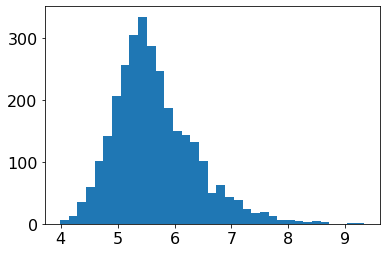

In [36]:
plt.hist(trace_calibration['p'], bins=35)
plt.show()

In [37]:
calibration_variable_names = [
    "std_deviation",
    "r1",
    "r2",
    "p",
]

100%|██████████| 4/4 [00:31<00:00,  7.81s/it]


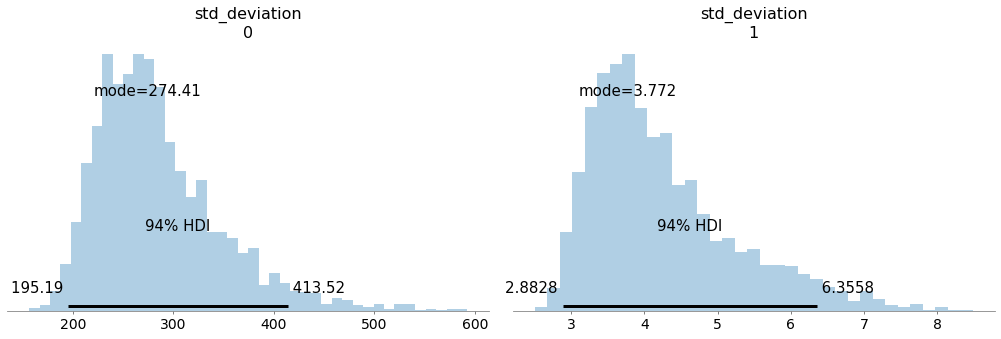

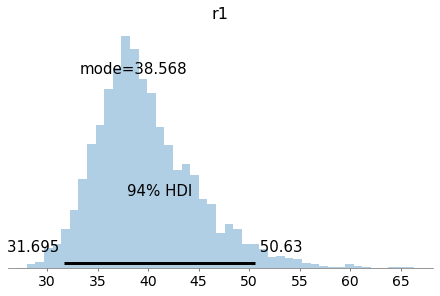

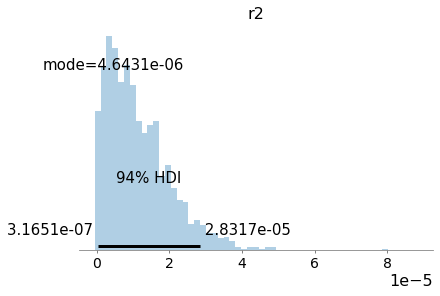

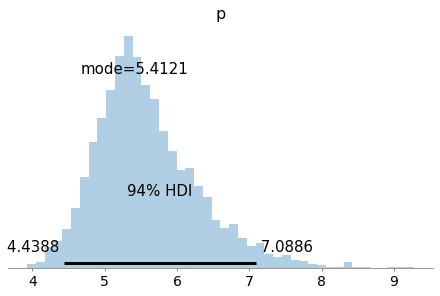

In [38]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=5,
        point_estimate="mode"
    )
    plt.savefig(f"{variable}_posterior_cal.png")

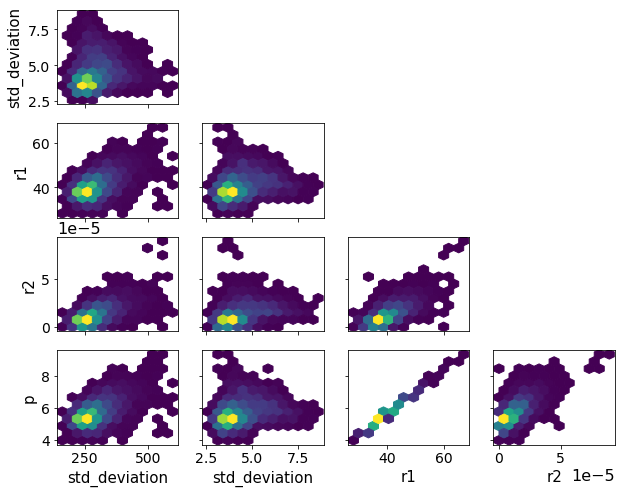

In [39]:
import arviz as az

az.plot_pair(
    trace_calibration,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    figsize=(10, 8),
)
plt.savefig("marginals_cal.png")

In [40]:
df_stats_summary = az.summary(
    data=trace_calibration,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

,mean,sd,hdi_3%,hdi_97%
std_deviation[0],290.577417,63.600582,1.951881e+02,413.523125
std_deviation[1],4.340872,1.015113,2.882820e+00,6.355826
r1,40.298869,5.139593,3.169516e+01,50.630000
r2,0.000012,0.000009,3.165111e-07,0.000028
p,5.653042,0.719167,4.438845e+00,7.088646


Auxiliary functions to compute the Most Probable Value (MPV):

In [41]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calulating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [42]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("stats_summary_calibration.csv")  # salvando em um csv para consultas

df_stats_summary

Calulating MPV from KDE for p: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]            


,mean,sd,hdi_3%,hdi_97%,mpv
std_deviation[0],290.577417,63.600582,1.951881e+02,413.523125,270.468740
std_deviation[1],4.340872,1.015113,2.882820e+00,6.355826,3.744997
r1,40.298869,5.139593,3.169516e+01,50.630000,38.507874
r2,0.000012,0.000009,3.165111e-07,0.000028,0.000005
p,5.653042,0.719167,4.438845e+00,7.088646,5.403977


In [43]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration["BKM_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration["BKM_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration["BKM_model"], 50, axis=0)

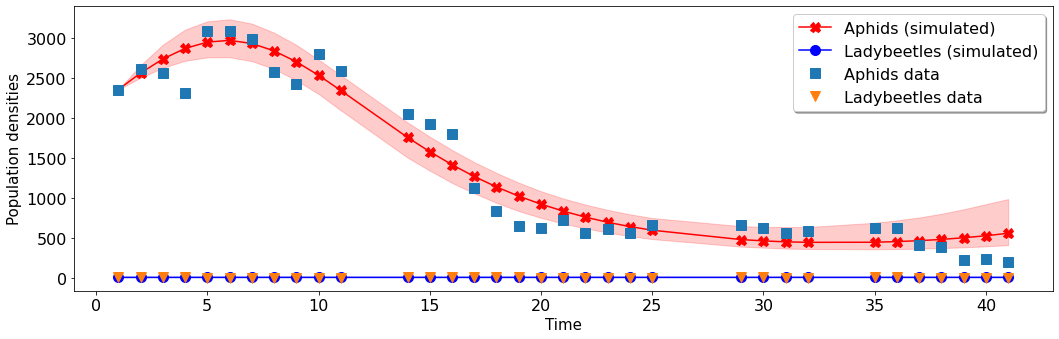

In [44]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("calibration.png", dpi=300)
plt.show()

In [45]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("calibration_realizations.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering p realizations: 100%|██████████| 3/3 [00:00<00:00, 828.86it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.025 seconds


In [46]:
df_realizations

,r1,r2,p
0,33.445674,4.786929e-07,4.695654
1,32.662854,4.339032e-06,4.585054
2,36.475173,3.158609e-06,5.120578
3,40.919166,3.283398e-06,5.746457
4,32.052881,3.005725e-06,4.499135
...,...,...,...
2995,46.075629,2.725312e-05,6.457623
2996,37.166809,2.096956e-05,5.209483
2997,36.286706,2.533552e-05,5.083099
2998,42.315511,1.261814e-05,5.934125


# Uncertainty propagation

In [47]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

start_time = time.time()
with model_smc:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration,
        var_names=["BKM_model"],
        random_seed=seed
    )["BKM_model"]  # Should we use likelihood_model or BKM_model?

duration = time.time() - start_time

In [48]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

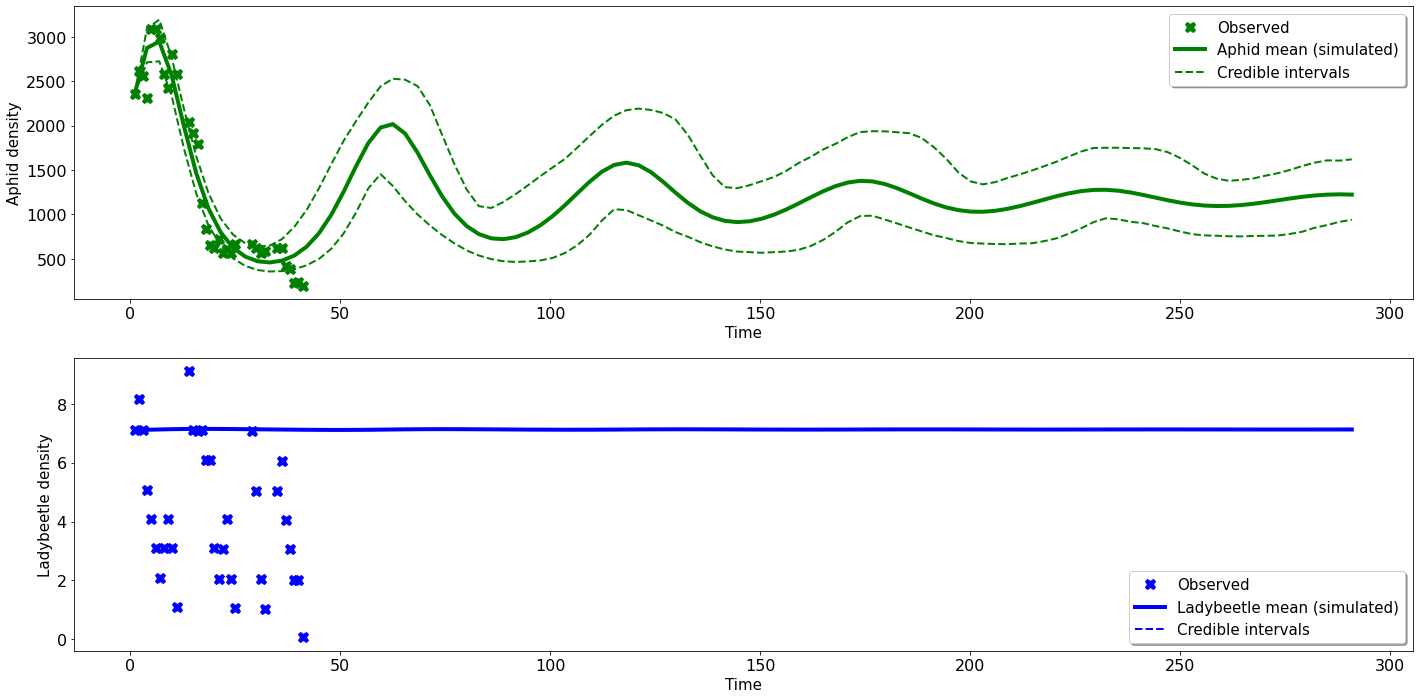

In [49]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("projections.png", dpi=300)
plt.show()